In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import cvxpy as cp

from decentr_qp import *
import ciropt as co

### Set the parameters for problem setup and generate random matrices and vectors

In [2]:
# random seed
np.random.seed(108)

# data generation
problem_spec = {}
problem_spec['n_node'] = 20
problem_spec['vector_size'] = 50
print(problem_spec)

problem_data = data_generation(problem_spec)
network_data = graph_generation(problem_spec['n_node'])
problem_data['itr_num'] = 1000

{'n_node': 20, 'vector_size': 50}


### Check the solution is different from unconstrained problem

In [3]:
f_star, x_opt_star = min_cvx_quad_constraint(problem_spec, problem_data, True)
print(f"{f_star=}, {np.linalg.norm(x_opt_star)=}")

unconstrained_f_star, unconstrained_x_opt_star = min_cvx_quad_constraint(problem_spec, problem_data, False)
if (f_star, x_opt_star) == (unconstrained_f_star, unconstrained_x_opt_star):
    print("Constraints have no meaning")
else:
    print("Constraints have meaning")

f_star=2.1948467594377177, np.linalg.norm(x_opt_star)=0.3135937994184582
Constraints have meaning


### Draw the network graph

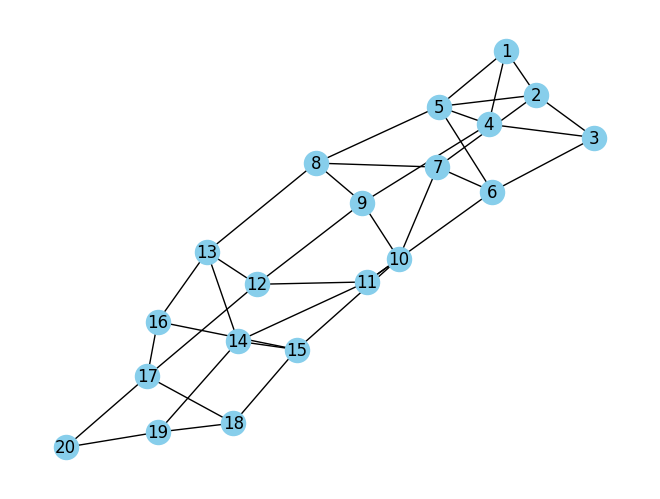

In [4]:
nx.draw(network_data["G"], node_color='skyblue', with_labels=True)
plt.savefig("plots/graph_n20.pdf")

### Define functions and proximal operators to implement the method

In [5]:
Q = problem_data['Q']
p = problem_data['p']
a = problem_data['a']
b = problem_data['b']
n_node = problem_spec['n_node']
vector_size = problem_spec['vector_size']

prox_operators = []
grad_h = []
f_plus_h = []

for jj in range(n_node):
    Qj, pj, aj, bj = Q[jj], p[jj], a[jj], b[jj]
    prox_operators += [lambda z, rho, aj=aj, bj=bj : prox_fj_quad_constraint(z, rho, aj, bj) ]
    grad_h += [lambda z, Qj=Qj, pj=pj : grad_hj_quad_constraint(z, Qj, pj) ]
    f_plus_h += [lambda x_kj, Qj=Qj, pj=pj : 1/2 * x_kj @ Qj @ x_kj.T + np.dot(pj, x_kj) ]

### Find the best working parameters for PG-EXTRA with grid search

In [6]:
# apply PG-EXTRA 
start, end, space = 0.01, 0.1, 0.005
best_value = 100

for r in np.arange(start, end, space) :
    problem_data['rho'] = round(r, 2)
    pg_op_norm, pg_err_opt_star, pg_err_opt_reldiff, pg_const_vio, pg_f_reldiff = co.pg_extra("pg_extra", problem_spec, problem_data, 
                                                                    network_data, x_opt_star, f_star, prox_operators=prox_operators,
                                                                    grad_h=grad_h, f_plus_h=f_plus_h,
                                                                    printing=False, freq=200)
    new_val = sum(pg_f_reldiff[300:400]) / 100
    if new_val < best_value:
        print("new best_rho :", round(r, 2),  ", new best_value :", new_val)
        best_value = new_val
        best_rho = round(r, 2)
    

print("best_rho :", best_rho)

new best_rho : 0.01 , new best_value : 6.397972770450372e-05
new best_rho : 0.02 , new best_value : 1.775525879344675e-06
new best_rho : 0.03 , new best_value : 1.6543004483079373e-08
new best_rho : 0.04 , new best_value : 3.9914755027893544e-10
new best_rho : 0.05 , new best_value : 3.765516849150645e-11
best_rho : 0.05


#### Run PG-EXRA with the best working parameter

In [7]:
problem_data['rho'] = best_rho

pg_op_norm, pg_err_opt_star, pg_err_opt_reldiff, pg_const_vio, pg_f_reldiff = co.pg_extra("pg_extra", problem_spec, problem_data, 
                                                                        network_data, x_opt_star, f_star, prox_operators=prox_operators,
                                                                        grad_h=grad_h, f_plus_h=f_plus_h,
                                                                        printing=True, freq=200)

ii=0, f_reldiff[-1]=0.9002983179989965, err_opt_reldiff[-1]=0.8956452780077516
ii=200, f_reldiff[-1]=1.5726629847456376e-07, err_opt_reldiff[-1]=6.188406471252419e-07
ii=400, f_reldiff[-1]=7.421562415352091e-13, err_opt_reldiff[-1]=3.877507837090037e-12
ii=600, f_reldiff[-1]=2.0233267217426638e-16, err_opt_reldiff[-1]=1.1246758602335832e-14
ii=800, f_reldiff[-1]=0.0, err_opt_reldiff[-1]=1.3003382268054918e-14
ii=999, f_reldiff[-1]=2.0233267217426638e-16, err_opt_reldiff[-1]=1.45017303403718e-14


### Run PG-EXTRA + Parallel C

In [8]:
params={"R":0.07, "Capacitance":0.3, "h":0.8}  

pg_c_op_norm, pg_c_err_opt_star, pg_c_err_opt_reldiff, pg_c_const_vio, pg_c_f_reldiff = co.pg_extra("pg_extra_par_c", problem_spec, problem_data, 
                                                                        network_data, x_opt_star, f_star, prox_operators=prox_operators,
                                                                        grad_h=grad_h, f_plus_h=f_plus_h,
                                                                        params=params, printing=True, freq=200)

ii=0, f_reldiff[-1]=0.917028633176678, err_opt_reldiff[-1]=0.8959053207128286
ii=200, f_reldiff[-1]=2.9599418595144777e-09, err_opt_reldiff[-1]=3.345561205475029e-08
ii=400, f_reldiff[-1]=4.0466534434853276e-16, err_opt_reldiff[-1]=1.6123131560646873e-15
ii=600, f_reldiff[-1]=2.0233267217426638e-16, err_opt_reldiff[-1]=6.194266764209533e-16
ii=800, f_reldiff[-1]=0.0, err_opt_reldiff[-1]=6.179820244968422e-16
ii=999, f_reldiff[-1]=0.0, err_opt_reldiff[-1]=6.260842865711411e-16


##### Running PG-EXTRA with same step size with PG-EXTRA + Parallel C

In [9]:
problem_data['rho'] = 0.07

pg_worse_op_norm, pg_worse_err_opt_star, pg_worse_err_opt_reldiff, pg_worse_const_vio, pg_worse_f_reldiff = co.pg_extra("pg_extra", problem_spec, problem_data, 
                                                                        network_data, x_opt_star, f_star, prox_operators=prox_operators,
                                                                        grad_h=grad_h, f_plus_h=f_plus_h,
                                                                        printing=True, freq=200)

ii=0, f_reldiff[-1]=0.917028633176678, err_opt_reldiff[-1]=0.8959053207128286
ii=200, f_reldiff[-1]=9.992428767919719e-06, err_opt_reldiff[-1]=8.51054509567229e-05
ii=400, f_reldiff[-1]=7.531366940212359e-09, err_opt_reldiff[-1]=6.414600368186506e-08
ii=600, f_reldiff[-1]=5.676443117849043e-12, err_opt_reldiff[-1]=4.8348200105698794e-11
ii=800, f_reldiff[-1]=4.046653443485328e-15, err_opt_reldiff[-1]=3.753327271931252e-14
ii=999, f_reldiff[-1]=0.0, err_opt_reldiff[-1]=1.3850495200821613e-14


## Plot the results

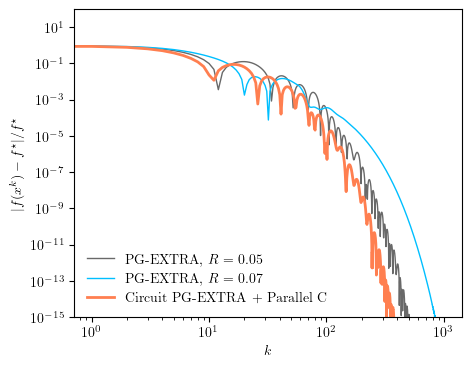

In [10]:
fname = "n20_circuit_pg_extra_par_c"

T = 1000
co.plot_methods([pg_f_reldiff[:T] ,pg_worse_f_reldiff[:T], pg_c_f_reldiff[:T]],
                ['PG-EXTRA, $R=0.05$', 'PG-EXTRA, $R=0.07$', 'Circuit PG-EXTRA + Parallel C'], 1e-15, 1e+2, fname)

#### Check the first iteration where the error falls below a certain criterion for each method

In [12]:
criterion = 1e-8

print( np.where(np.array(pg_c_f_reldiff) < criterion)[0][0] )
print( np.where(np.array(pg_f_reldiff) < criterion)[0][0] )
print( np.where(np.array(pg_worse_f_reldiff) < criterion)[0][0] )

147
214
393
